# Bespoke Books - Pictures to Coloring Book Example

This notebook demonstrates the core logic for turning a folder of images into a coloring book using either OpenAI or Gemini.

## Set API Keys

Uncomment and fill in your API keys for the providers you want to use.

In [ ]:
import os
from PIL import Image
# os.environ['OPENAI_API_KEY'] = 'sk-your-openai-key'
os.environ['GEMINI_API_KEY'] = 'your-gemini-key'

## Configuration

In [13]:
from pathlib import Path
IMAGE_FOLDER = Path('images')
OUTPUT_FOLDER = Path('outputs')
OUTPUT_FOLDER.mkdir(exist_ok=True)

# Provider and style selection
PROVIDER = 'gemini'  # or 'openai'

prompt_template = ("Transform the provided image into the artistic style of a child’s coloring book. "
                   "Preserve the original composition but render it as if the characters are {style_string}, "
                   "showing this style clearly by adding items as needed, but with high contrast black and white outlines. "
                   "There should be no non black and white colors in the image. Make lines clean and well-defined.")

DEFAULT_PROMPTS = {
    'standard': ("Transform the provided image into the artistic style of a child’s coloring book. "
                 "Preserve the original composition but render it in a clean, high contrast black and white outline, "
                 "suitable to color in. There should be no non black and white colors in the image. "
                 "Make lines clean and well-defined."),
    'cowboys': prompt_template.format(style_string="cowboys"),
    'pirates': prompt_template.format(style_string="pirates"),
    'fantasy': prompt_template.format(style_string="in a fantasy book like lord of the rings"),
    'astronauts': prompt_template.format(style_string="astronauts"),
    'cover_addition': 'Add the text "{title}" as a title on the image in a google title font.'
}

def get_style_prompt(style_key: str) -> str:
    return DEFAULT_PROMPTS.get(style_key, DEFAULT_PROMPTS['standard'])

# One-line style selector and book metadata
STYLE = 'cowboys'  # choose: 'standard', 'cowboys', 'pirates', 'fantasy', 'astronauts'
TITLE =  "Arthur's Coloring Book"
COVER_COLOR = '#ADD8E6'  # Hex color for the cover page background, e.g. '#FFEECC'

# Base prompt for interior pages based on selected style
PROMPT = get_style_prompt(STYLE)

# Optional: if you want to generate a special cover image, set COVER_IMAGE to a path in IMAGE_FOLDER
# and the prompt will include the title text.
COVER_IMAGE = None  # e.g., IMAGE_FOLDER / 'cover.jpg' or None

def get_cover_prompt(title: str, style_key: str) -> str:
    base = get_style_prompt(style_key)
    addition = DEFAULT_PROMPTS['cover_addition'].format(title=title)
    return f"{base} {addition}"

## Process Images

Using Gemini
Saved outputs/set1_photo_coloring.png
Using Gemini
Saved outputs/set2_photo_coloring.png


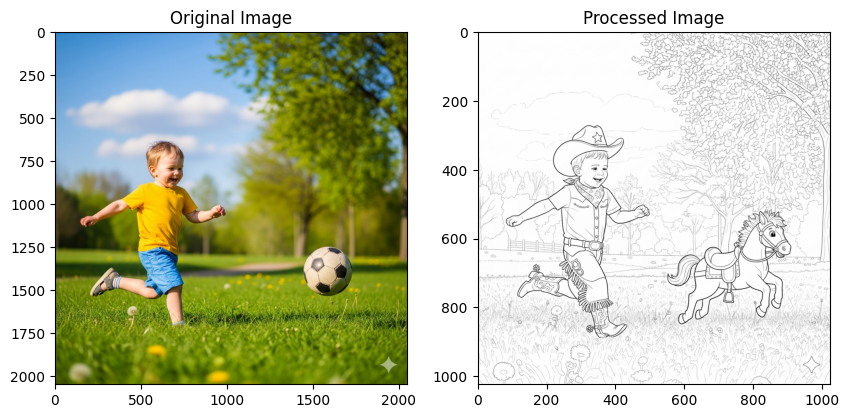

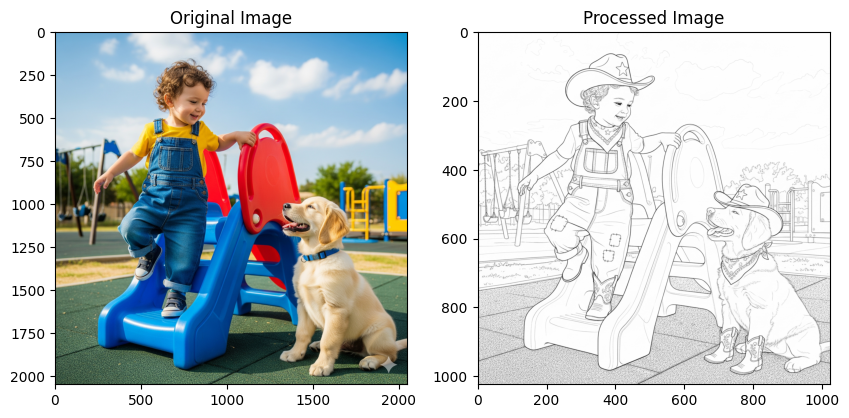

In [14]:
import asyncio
import matplotlib.pyplot as plt
import matplotlib.cm
from image_providers import ImageProvider
provider = ImageProvider(PROVIDER)

async def process_images():
    # Optional cover image generation
    if COVER_IMAGE:
        cover_prompt = get_cover_prompt(TITLE, STYLE)
        result = await provider.edit_image(str(COVER_IMAGE), cover_prompt)
        out_path = OUTPUT_FOLDER / 'cover_coloring.png'
        result.save(out_path)
        print('Saved', out_path)

    # Interior pages
    for img_path in IMAGE_FOLDER.glob('*'):
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg']:
            continue
        result = await provider.edit_image(str(img_path), PROMPT)
        out_path = OUTPUT_FOLDER / f'{img_path.stem}_coloring.png'
        result.save(out_path)
        print('Saved', out_path)
        #print each original image side by side with the processed image

        # Load the images
        original_image = Image.open(img_path)
        processed_image = Image.open(out_path)

        #make sure processed image is gray scale -> this is not in the web service since it's slow, going to do a faster version and bring it over
        #gemini (and sometimes openai) is not always good at listening to the requirement to be black and white
        processed_image = processed_image.convert('L')
        #save the processed image
        processed_image.save(out_path)


        # Create a new figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Display the original image
        ax1.imshow(original_image)
        ax1.set_title('Original Image')

        # Display the processed image
        ax2.imshow(processed_image, cmap='gray')
        ax2.set_title('Processed Image')
    

await process_images()



## Build PDF

In [15]:
from pathlib import Path
from typing import Tuple
from PIL import Image
from fpdf import FPDF

def hex_to_rgb(hex_color: str) -> Tuple[int, int, int]:
    hex_color = hex_color.lstrip('#')
    if len(hex_color) == 3:
        hex_color = ''.join(ch * 2 for ch in hex_color)
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))  # type: ignore[return-value]

pdf = FPDF(unit='pt', format='letter')

# Front cover
pdf.add_page()
r, g, b = hex_to_rgb(COVER_COLOR)
pdf.set_fill_color(r, g, b)
pdf.rect(0, 0, pdf.w, pdf.h, 'F')

# Choose text color based on background brightness
brightness = r * 0.299 + g * 0.587 + b * 0.114
if brightness > 128:
    pdf.set_text_color(0, 0, 0)
else:
    pdf.set_text_color(255, 255, 255)

pdf.set_font('Arial', 'B', 36)

# If a generated cover image exists, place it; otherwise center the title text
cover_img_path = OUTPUT_FOLDER / 'cover_coloring.png'
if cover_img_path.exists():
    margin = 36
    max_width = pdf.w - 2 * margin
    max_height = pdf.h - 2 * margin
    with Image.open(cover_img_path) as img:
        img_width, img_height = img.size
    scale = min(max_width / img_width, max_height / img_height)
    new_width = img_width * scale
    new_height = img_height * scale
    x = (pdf.w - new_width) / 2
    y = (pdf.h - new_height) / 2
    pdf.image(str(cover_img_path), x=x, y=y, w=new_width, h=new_height)
else:
    title_width = pdf.get_string_width(TITLE)
    x = (pdf.w - title_width) / 2
    y = pdf.h * 0.3
    pdf.set_xy(x, y)
    pdf.cell(title_width, 10, TITLE, 0, 1, 'C')

# Interior pages
interior_images = sorted(
    [p for p in OUTPUT_FOLDER.glob('*_coloring.png') if p.name != 'cover_coloring.png']
)
for img_file in interior_images:
    pdf.add_page()
    margin = 36
    max_width = pdf.w - 2 * margin
    max_height = pdf.h - 2 * margin
    with Image.open(img_file) as img:
        img_width, img_height = img.size
    scale = min(max_width / img_width, max_height / img_height)
    new_width = img_width * scale
    new_height = img_height * scale
    x = (pdf.w - new_width) / 2
    y = (pdf.h - new_height) / 2
    pdf.image(str(img_file), x=x, y=y, w=new_width, h=new_height)

PDF_OUTPUT = 'coloring_book.pdf'
pdf.output(PDF_OUTPUT)
print('PDF saved to', PDF_OUTPUT)

PDF saved to coloring_book.pdf
